<a href="https://colab.research.google.com/github/AyishaR/Distance-in-frame/blob/master/Distance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import math
import tensorflow_hub as hub

# Human detection

Tensorflow object detection

CenterNet HourGlass104 Keypoints 512x512

In [ ]:
hub_model = hub.load("https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1")

# How

1. Detect humans in the image/frame.
2. Calculate lower centre of bounding box.
3. Calculate distance of human(s) from camera.
    * We need to calculate a perceived focal length
    * We also need the actual height of the object in frame. Here, we will take that to be the average human height.
4. Calculate the distance between objects

## Prerequisites and assumptions



#### **Camera configuration**
 
Aperture = f/1.7
This is the configuration of my phone camera.

We will need an image for pre calculation.
This reference image is 4000 X 1824. We can either resize the input images to the same size or perform the pre calculations on a resized reference image to match that of the input image. 

Here, I have resized the input images to 583 X 1280

#### **Assumptions**

Average height of a human in india

 ah = 158.76    



#### **Variables**

a = 1/1.7
 
 ph  -  height in pixels

 ah  -  actual height, here, average height

 f   -  perceived focal length

 d   -  distance from centre of camera plane



In [ ]:
AH = 158.76 
f = 3172
a = 1/1.7

#### **Pre required calculation**
 
Perceived focal length (f) is calculated by placing an object with known dimensions (ah) at a known distance (d).
 
Here, I placed a pen at a distance to fill the image. The dimensions of the image
 
Known values,
 
ah = lenght of pen = 14.5 cm
 
ph = pixels in image = 4000
 
d = 11.5 cm
 
f = (ph * d)/(ah) = 3172
 
Now, distance can be calculated as *d = (f * ah)/(ph)*

In [ ]:
pen = cv2.imread("/content/IMG_20200820_113751.jpg")
#resize only to enable visualization
pen = cv2.resize(pen, (400, int(400*(pen.shape[0]/pen.shape[1]))))
print(pen.shape)
cv2_imshow(pen)

AttributeError: ignored

In [ ]:
def distance(p1):
    #defining midpoints
    m1 = [(p1[0] + p1[2])//2, p1[3]]
   
    #distance measurement from centre of camera plane
    d1 = (f * AH) / (p1[3] - p1[1])
    
    return d1

In [ ]:
def distance_between(p1, p2, c):
    #defining midpoints
    m1 = [(p1[0] + p1[2])//2, p1[3]]
    m2 = [(p2[0] + p2[2])//2, p2[3]]
 
    #distance measurement from centre of camera plane
    d1 = (f * AH) / (p1[3] - p1[1])
    d2 = (f * AH) / (p2[3] - p1[1])
    
    #angle between two points wrt centre of camera plane
    angle = find_angle(np.array(m1), np.array([c[1]/2, c[0]]), np.array(m2)) 
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
    #calculate distance as third side of triangle
    d3 = math.sqrt((d1 * d1) + (d2 * d2) - (2 * d1 * d2 * np.cos(angle * a)))
    
    return d3

In [ ]:
def find_angle(a, b, c):
    ba = a-b
    bc = c-b
 
    co = np.dot(ba, bc)/ (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(co)
 
    return angle

# Distance between two people in the same frame

Image shape:  (4000, 1824, 3)
Input shape:  (1, 4000, 1824, 3)
Distance of person  0  =  538.6113 cm
Distance of person  1  =  638.3845 cm
Distance between them =  112.10681290626364


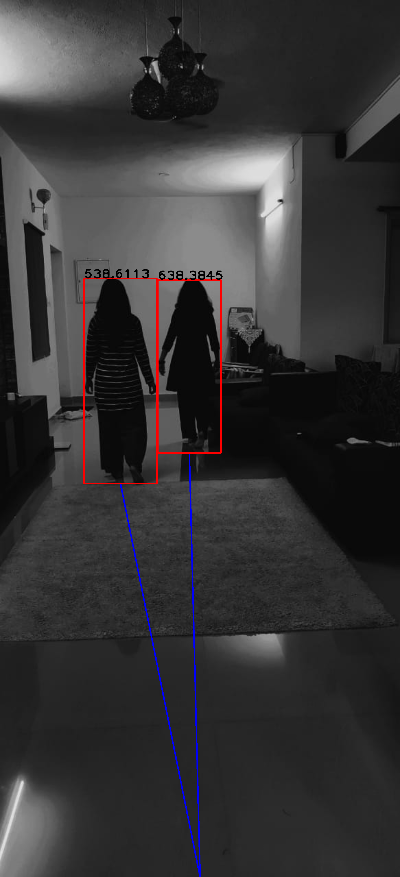

In [ ]:
image = cv2.imread("/content/sample.jpeg")
image = cv2.resize(image, (1824, 4000))
print("Image shape: ", image.shape)
 
# RESIZE AND GIVE AS INPUT TO MODEL
 
img = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])).astype(np.uint8)
print("Input shape: ", img.shape)
results = hub_model(img)
 
 
# FIND INSTANCES OF HUMAN DETECTION
 
indices = np.where(np.array(results['detection_classes'][0]) == 1.0)[0]
 
 
# DRAW BOUNDING BOXES AND LINE TO CENTRE OF CAMERA PLANE
 
xx, yy = image.shape[1], image.shape[0]     # because the coordinates of bounding boxes are normalised
person = []
for i in indices:
    if (results['detection_scores'][0][i] > 0.6):
        y1, x1, y2, x2 = results['detection_boxes'][0][i]
        person.append([x1*xx, y1*yy, x2*xx, y2*yy])     # appending as xmin, ymin, xmax, ymax
        cv2.line(image, ((x1*xx + x2*xx)//2, y2*yy), (int(image.shape[1]/2), image.shape[0]), (255,0,0), 5) #line
        cv2.rectangle(image, (x1*xx, y1*yy), (x2*xx, y2*yy), (0, 0, 255), 5)


# CALCULATE DISTANCE FROM CAMERA
for x, p in enumerate(person):
    d = distance(p)
    print("Distance of person ", x, " = ", d.numpy(), "cm")
    image = cv2.putText(image, str(d.numpy()), (p[0], p[1]), cv2.FONT_HERSHEY_PLAIN, 4, (0,0,0), 5)


# CALCULATE DISTANCE BETWEEN 2 PEOPLE
 
d3 = distance_between(person[0], person[1], image.shape)
print("Distance between them = ", d3)


# resize to be able to display
image = cv2.resize(image, (400, int(400*(image.shape[0]/image.shape[1]))))
 
cv2_imshow(image)

The actual distance was 108cm.
 
The difference in actual vs calculated value is due to the difference in assumed actual height and the height of the people in the frame. 
 
Since the current use case does not require precise measurements, this difference is acceptable.
 
If the actual height of the measured object does not change, this method will produce more precise measurements

## Use cases
 
* Social distance surveillance - Maintaing social distance is an important factor in curbing the spread of the virus. This script can be used to identify the distance between people in a video footage to ensure that they are sufficiently far apart.
 
* Personal social distance maintenance - It can be used to find how far we are from others standing around us. 
 
* It can be applied to any situation to find the distance between recognizable objects of known size.

## Video

In [ ]:
cap = cv2.VideoCapture('')

In [ ]:
if cap.isOpened():
    ret, image = cap.read()
    if ret:
        image = cv2.resize(image, (1824, 4000))
        print("Image shape: ", image.shape)

        # RESIZE AND GIVE AS INPUT TO MODEL

        img = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])).astype(np.uint8)
        print("Input shape: ", img.shape)
        results = hub_model(img)


        # FIND INSTANCES OF HUMAN DETECTION

        indices = np.where(np.array(results['detection_classes'][0]) == 1.0)[0]


        # DRAW BOUNDING BOXES AND LINE TO CENTRE OF CAMERA PLANE

        xx, yy = image.shape[1], image.shape[0]     # because the coordinates of bounding boxes are normalised
        person = []
        for i in indices:
            if (results['detection_scores'][0][i] > 0.7):
                y1, x1, y2, x2 = results['detection_boxes'][0][i]
                person.append([x1*xx, y1*yy, x2*xx, y2*yy])     # appending as xmin, ymin, xmax, ymax
                cv2.line(image, ((x1*xx + x2*xx)//2, y2*yy), (int(image.shape[1]/2), image.shape[0]), (255,0,0), 5) #line
                cv2.rectangle(image, (x1*xx, y1*yy), (x2*xx, y2*yy), (0, 0, 255), 5)


        # CALCULATE DISTANCES

        d1, d2, d3 = distance(person[0], person[1], image.shape)
        print("Distance of person1 = ", d1.numpy())
        print("Distance of person2 = ", d2.numpy())
        print("Distance between them = ", d3.numpy())
        
        # resize to be able to display
        image = cv2.resize(image, (400, int(400*(image.shape[0]/image.shape[1]))))

        cv2_imshow(image)

# Reference

https://www.tensorflow.org/hub/tutorials/tf2_object_detection#build_a_detection_model_and_load_pre-trained_model_weights

In [ ]:
import os

os.path.exists("/content/pen.jpeg")

True